In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import ticker
from matplotlib.colors import TwoSlopeNorm
import cartopy
import cartopy.crs as ccrs

In [2]:
from importlib.machinery import SourceFileLoader
plotting = SourceFileLoader("plotting", "../../plotting.py").load_module()

In [3]:
import warnings
warnings.filterwarnings("ignore") 

## Functions

In [4]:
def wgt_time_mean(da, wgt):
    # da is already multiplied by wgt in pop
    # mean = (da*wgt).sum(dim='time')/wgt.sum(dim='time')
    mean = da.sum(dim='time')/wgt.sum(dim='time')
    return mean 

# Set up dask

In [5]:
import os
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

USER = os.environ['USER']

In [6]:
cluster = PBSCluster(
    cores=1,
    memory='20GB',
    processes=1,
    queue='casper',
    local_directory=f'/glade/scratch/{USER}/dask-workers',
    log_directory=f'/glade/scratch/{USER}/dask-workers',
    resource_spec='select=1:ncpus=1:mem=20GB',
    project='P93300070',
    walltime='03:00:00',
    interface='ib0')

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:37434,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
cluster.scale(20)

# Import Data

In [8]:
TAREA = xr.open_dataset('/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.nday1.0001-01-01.nc').TAREA

In [9]:
biomes = xr.open_dataset('../data/biomes_regrid_pop.nc')
biomes_cam = xr.open_dataset('../data/biomes_regrid_cam.nc')

In [71]:
%%time

base = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/daily/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.ecosys.nday1.'

data = xr.open_mfdataset(base+'*.nc', concat_dim="time", parallel = True, chunks = {'time':120},
                              data_vars='minimal', compat='override', 
                              coords='minimal')
data

CPU times: user 958 ms, sys: 31.2 ms, total: 989 ms
Wall time: 11.3 s


<xarray.Dataset>
Dimensions:                     (time: 10950, nlat: 384, nlon: 320)
Coordinates:
  * time                        (time) object 0020-01-01 00:00:00 ... 0049-12...
    ULONG                       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables: (12/14)
    totChl                      (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    totChl_sat_nocld            (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    totChl_sat_nocld_wgt        (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    totChl_isccp_wgt            (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    totChl_isccp                (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    totChl_modis                (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    ...                          ...
    totChl_sat_nocld_wgt_swath  (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    totChl_modis_swath          (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    totChl_modis_wgt_swath      (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    cloudfrac_modis             (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    cloudfrac_isccp             (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>
    cloudfrac_wgt               (time, nlat, nlon) float32 dask.array<chunksize=(120, 384, 320), meta=np.ndarray>

In [ ]:
%%time
files = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/atm/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.cam.h1.*.nc'

cloud_data = xr.open_mfdataset(files, concat_dim="time", parallel = True, chunks={'time': 365}, 
                               data_vars='minimal', compat='override', 
                               coords='minimal')

In [ ]:
cloud_data = cloud_data.sel(time=slice('0020-01-01','0040-12-31'))
cloud_data['CLDTOT']

# Calculate Climatologies

chunks = {"nlat": 50, "nlon": 50}

In [ ]:
%%time
cloud_mean = cloud_data.CLDTOT.mean(dim='time').compute()
cloud_mean = cloud_mean.to_dataset(name = 'cloud_tot')
cloud_mean.to_netcdf('../data/cldtot_mean.nc')

In [ ]:
%%time 
cloudfrac_modis_mean = wgt_time_mean(data.cloudfrac_modis, data.cloudfrac_wgt)
cloudfrac_modis_mean = cloudfrac_modis_mean.to_dataset(name = 'modis_clouds')
cloudfrac_modis_mean.to_netcdf('../data/cloudfrac_modis_mean.nc')

In [ ]:
%%time 
cloudfrac_isccp_mean = wgt_time_mean(data.cloudfrac_isccp, data.cloudfrac_wgt)
cloudfrac_isccp_mean = cloudfrac_isccp_mean.to_dataset(name = 'isccp_clouds')
cloudfrac_isccp_mean.to_netcdf('../data/cloudfrac_isccp_mean.nc')

In [ ]:
%%time
total_chlor_time_mean = data.totChl.mean(dim='time').compute()
total_chlor_time_mean = total_chlor_time_mean.to_dataset(name = 'totChl')
total_chlor_time_mean.to_netcdf('../data/total_chlor_time_mean.nc')

In [ ]:
%%time
baseline_chlor_time_mean = wgt_time_mean(data.totChl_sat_nocld, data.totChl_sat_nocld_wgt)
baseline_chlor_time_mean = baseline_chlor_time_mean.to_dataset(name = 'baseline_chlor')
baseline_chlor_time_mean.to_netcdf('../data/baseline_chlor_time_mean.nc')

In [ ]:
%%time
isccp_chlor_time_mean = wgt_time_mean(data.totChl_isccp, data.totChl_isccp_wgt)
isccp_chlor_time_mean = isccp_chlor_time_mean.to_dataset(name = 'isccp_chlor')
isccp_chlor_time_mean.to_netcdf('../data/isccp_chlor_time_mean.nc')

In [ ]:
%%time
modis_chlor_time_mean = wgt_time_mean(data.totChl_modis, data.totChl_modis_wgt)
modis_chlor_time_mean = modis_chlor_time_mean.to_dataset(name = 'modis_chlor')
modis_chlor_time_mean.to_netcdf('../data/modis_chlor_time_mean.nc')

In [ ]:
%%time
modis_chlor_time_mean_swath = wgt_time_mean(data.totChl_modis_swath, data.totChl_modis_wgt_swath)
modis_chlor_time_mean_swath = modis_chlor_time_mean_swath.to_dataset(name = 'modis_chlor_swath')
modis_chlor_time_mean_swath.to_netcdf('../data/modis_chlor_time_mean_swath.nc')

In [ ]:
%%time
baseline_chlor_time_mean_swath = wgt_time_mean(data.totChl_sat_nocld_swath, data.totChl_sat_nocld_wgt_swath)
baseline_chlor_time_mean_swath = baseline_chlor_time_mean_swath.to_dataset(name = 'baseline_chlor_swath')
baseline_chlor_time_mean_swath.to_netcdf('../data/baseline_chlor_time_mean_swath.nc')

# Merge into single dataset

In [10]:
total_chlor_time_mean = xr.open_dataset('../data/total_chlor_time_mean.nc')
baseline_chlor_time_mean = xr.open_dataset('../data/baseline_chlor_time_mean.nc')
isccp_chlor_time_mean = xr.open_dataset('../data/isccp_chlor_time_mean.nc')
modis_chlor_time_mean = xr.open_dataset('../data/modis_chlor_time_mean.nc')
modis_chlor_time_mean_swath = xr.open_dataset('../data/modis_chlor_time_mean_swath.nc')
baseline_chlor_time_mean_swath = xr.open_dataset('../data/baseline_chlor_time_mean_swath.nc')

In [11]:
data_mean = xr.merge([total_chlor_time_mean, baseline_chlor_time_mean, isccp_chlor_time_mean,
                  modis_chlor_time_mean, modis_chlor_time_mean_swath, baseline_chlor_time_mean_swath])

In [13]:
modis_clouds = xr.open_dataset('../data/cloudfrac_modis_mean.nc')
isccp_clouds = xr.open_dataset('../data/cloudfrac_isccp_mean.nc')

# Make Climatology Plots

### Clouds

In [14]:
modis_clouds_ds = plotting.pop_add_cyclic(modis_clouds)
isccp_clouds_ds = plotting.pop_add_cyclic(isccp_clouds)

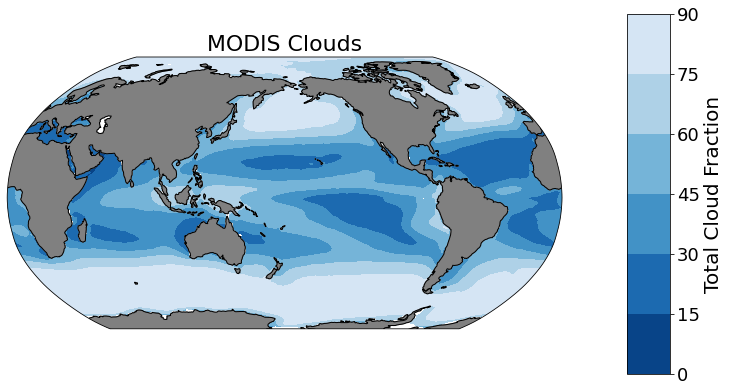

In [15]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(20,5))

im1 = axs.contourf(modis_clouds_ds.TLONG, modis_clouds_ds.TLAT, modis_clouds_ds.modis_clouds,
              transform = ccrs.PlateCarree(), cmap='Blues_r', shading='auto', vmin=0,  vmax = 100)

axs.set_title('MODIS Clouds', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

# [left, bottom, width, height]
cax = fig.add_axes([0.75, 0, 0.03, 1])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Total Cloud Fraction', size = 20)
plt.savefig('../plots/modis_clouds_climatology.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

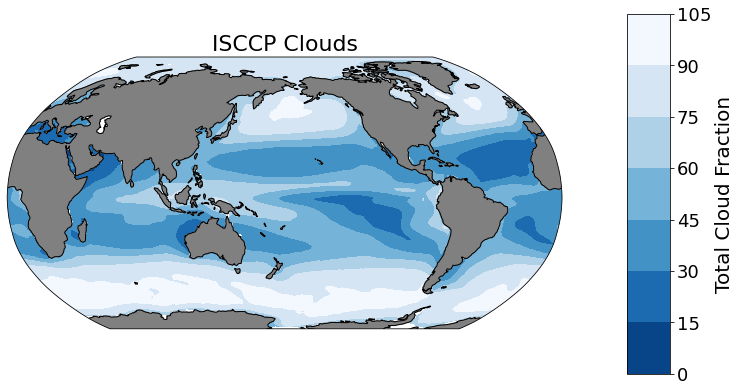

In [16]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(20,5))

im1 = axs.contourf(isccp_clouds_ds.TLONG, isccp_clouds_ds.TLAT, isccp_clouds_ds.isccp_clouds,
              transform = ccrs.PlateCarree(), cmap='Blues_r', shading='auto', vmin=0,  vmax = 100)

axs.set_title('ISCCP Clouds', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

# [left, bottom, width, height]
cax = fig.add_axes([0.75, 0, 0.03, 1])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Total Cloud Fraction', size = 20)
plt.savefig('../plots/isccp_clouds_climatology.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

### Chlorophyll

In [17]:
totChl_ds = plotting.pop_add_cyclic(data_mean.totChl.to_dataset(name = 'totChl'))

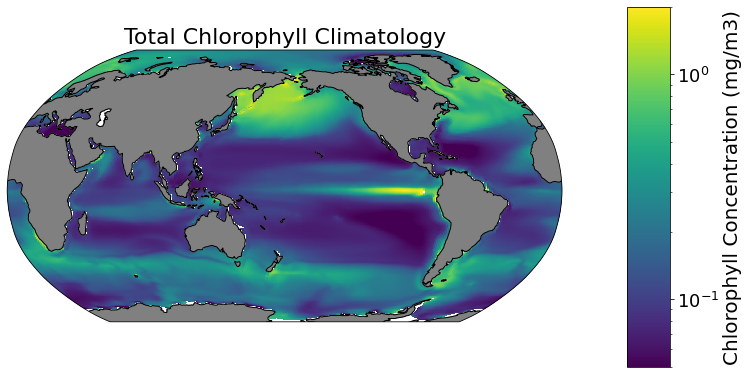

In [18]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(20,5))

axs.set_title('Total Chlorophyll Climatology', fontsize = 22)
norm = colors.LogNorm(vmin = 0.05, vmax = 2)

im1 = axs.pcolormesh(totChl_ds.TLONG, totChl_ds.TLAT, totChl_ds.totChl, 
                   transform = ccrs.PlateCarree(), norm=norm, cmap='viridis')

axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

# [left, bottom, width, height]
cax = fig.add_axes([0.75, 0, 0.03, 1])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Chlorophyll Concentration (mg/m3)', size = 20)
plt.savefig('../plots/total_chlor_climatology.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [ ]:
# fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
#                         figsize=(20,5))

# axs.set_title('Total Chlorophyll Climatology', fontsize = 22)

# im1 = axs.contourf(totChl_ds.TLONG, totChl_ds.TLAT, totChl_ds.totChl, 
#                    transform = ccrs.PlateCarree(), cmap='viridis', locator = ticker.LogLocator(), 
#                    levels = 10, vmax = 4)

# axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
# axs.coastlines(color = 'black', linewidth = 1)

# # [left, bottom, width, height]
# cax = fig.add_axes([0.75, 0, 0.03, 1])

# cbar = plt.colorbar(im1, cax = cax)
# cbar.ax.tick_params(labelsize=18)
# cbar.set_label(label = 'Chlorophyll Concentration (mg/m3)', size = 20)

In [19]:
baseline_chlor_ds = plotting.pop_add_cyclic(data_mean.baseline_chlor.to_dataset(name = 'baseline_chlor'))

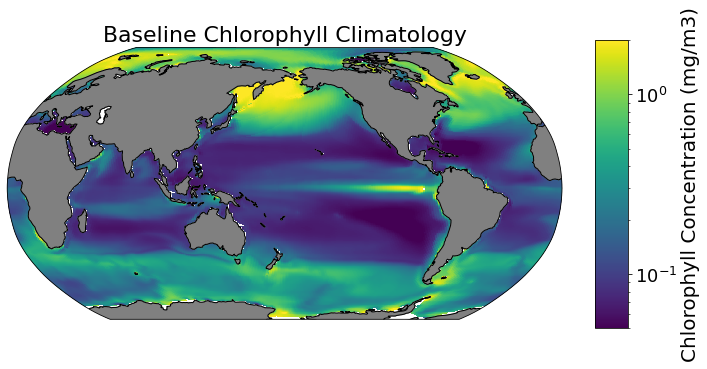

In [20]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

axs.set_title('Baseline Chlorophyll Climatology', fontsize = 22)
norm = colors.LogNorm(vmin = 0.05, vmax = 2)

im1 = axs.pcolormesh(baseline_chlor_ds.TLONG, baseline_chlor_ds.TLAT, baseline_chlor_ds.baseline_chlor, 
                   transform = ccrs.PlateCarree(), norm=norm, cmap='viridis')

axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

# [left, bottom, width, height]
cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Chlorophyll Concentration (mg/m3)', size = 20)
plt.savefig('../plots/baseline_chlor_climatology.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [21]:
baseline_total_diff = 100*((data_mean.baseline_chlor - data_mean.totChl)/data_mean.totChl)
baseline_total_diff = plotting.pop_add_cyclic(baseline_total_diff.to_dataset(name = 'baseline_total_diff'))

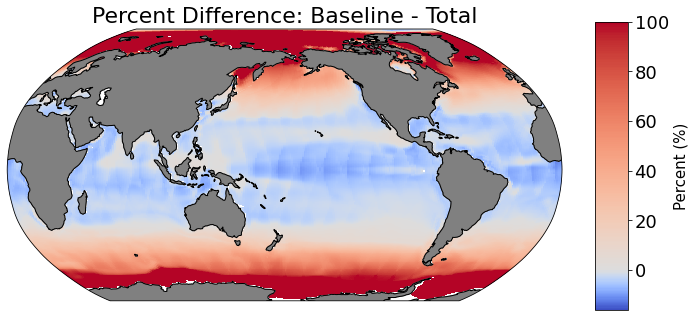

In [24]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.pcolormesh(baseline_total_diff.TLONG, baseline_total_diff.TLAT, baseline_total_diff.baseline_total_diff, 
                   transform = ccrs.PlateCarree(), norm=TwoSlopeNorm(0), vmax = 100, cmap='coolwarm')

axs.set_title('Percent Difference: Baseline - Total', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Percent (%)', size = 15)
plt.savefig('../plots/baseline_total_per_diff.png', bbox_inches = 'tight', pad_inches = 0.3, dpi = 300)

In [26]:
modis_chlor_ds = plotting.pop_add_cyclic(data_mean.modis_chlor.to_dataset(name = 'modis_chlor'))

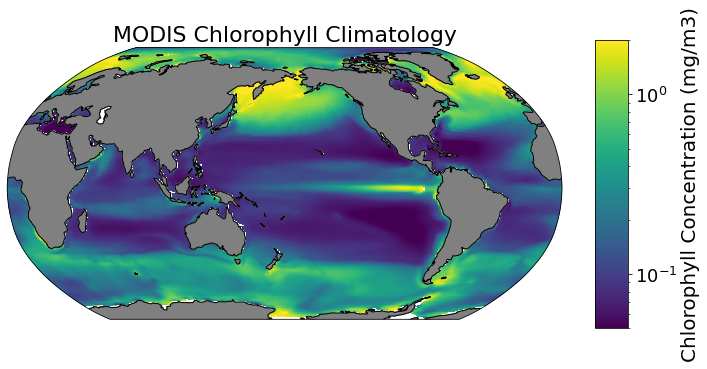

In [27]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

axs.set_title('MODIS Chlorophyll Climatology', fontsize = 22)
norm = colors.LogNorm(vmin = 0.05, vmax = 2)

im1 = axs.pcolormesh(modis_chlor_ds.TLONG, modis_chlor_ds.TLAT, modis_chlor_ds.modis_chlor, 
                   transform = ccrs.PlateCarree(), norm=norm, cmap='viridis')

axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

# [left, bottom, width, height]
cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Chlorophyll Concentration (mg/m3)', size = 20)
plt.savefig('../plots/modis_chlor_climatology.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [28]:
isccp_chlor_ds = plotting.pop_add_cyclic(data_mean.isccp_chlor.to_dataset(name = 'isccp_chlor'))

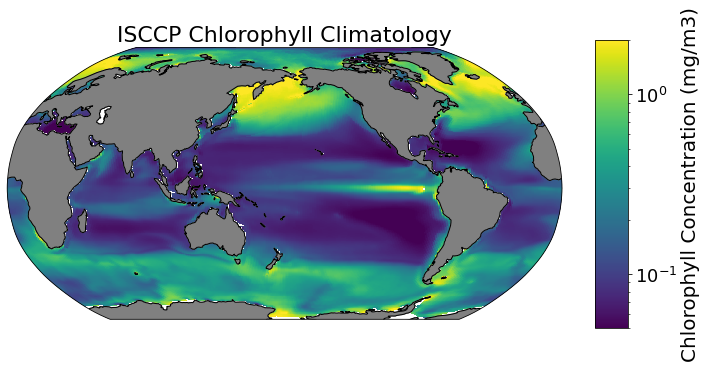

In [29]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

axs.set_title('ISCCP Chlorophyll Climatology', fontsize = 22)
norm = colors.LogNorm(vmin = 0.05, vmax = 2)

im1 = axs.pcolormesh(isccp_chlor_ds.TLONG, isccp_chlor_ds.TLAT, isccp_chlor_ds.isccp_chlor, 
                   transform = ccrs.PlateCarree(), norm=norm, cmap='viridis')

axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

# [left, bottom, width, height]
cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Chlorophyll Concentration (mg/m3)', size = 20)
plt.savefig('../plots/isccp_chlor_climatology.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [30]:
modis_isccp_diff = 100*(data_mean.modis_chlor - data_mean.isccp_chlor)/data_mean.isccp_chlor
modis_isccp_diff = plotting.pop_add_cyclic(modis_isccp_diff.to_dataset(name = 'modis_isccp_diff'))

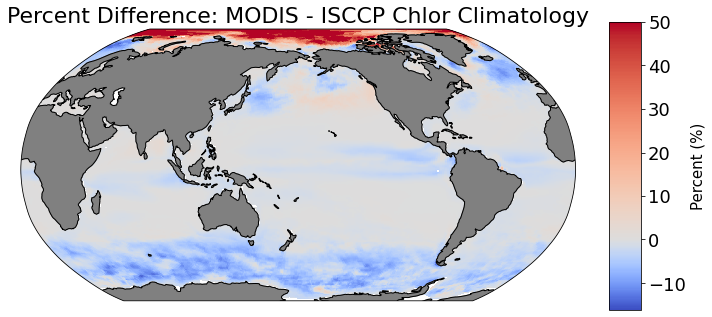

In [33]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.pcolormesh(modis_isccp_diff.TLONG, modis_isccp_diff.TLAT, modis_isccp_diff.modis_isccp_diff, 
                   transform = ccrs.PlateCarree(), norm=TwoSlopeNorm(0), vmax = 50, cmap='coolwarm')

axs.set_title('Percent Difference: MODIS - ISCCP Chlor Climatology', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Percent (%)', size = 15)
plt.savefig('../plots/modis_isccp_chlor_per_diff.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [34]:
modis_baseline_per_diff = 100*(data_mean.modis_chlor - data_mean.baseline_chlor)/data_mean.baseline_chlor
modis_baseline_per_diff = plotting.pop_add_cyclic(modis_baseline_per_diff.to_dataset(name = 'modis_baseline_diff'))

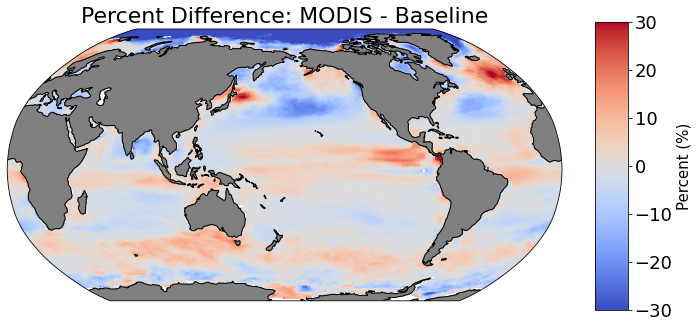

In [37]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.pcolormesh(modis_baseline_per_diff.TLONG, modis_baseline_per_diff.TLAT, modis_baseline_per_diff.modis_baseline_diff, 
                   transform = ccrs.PlateCarree(), vmin = -30, vmax = 30, cmap='coolwarm')

axs.set_title('Percent Difference: MODIS - Baseline', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Percent (%)', size = 15)
plt.savefig('../plots/modis_baseline_per_diff.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [38]:
modis_baseline_diff = (data_mean.modis_chlor - data_mean.baseline_chlor)
modis_baseline_diff = plotting.pop_add_cyclic(modis_baseline_diff.to_dataset(name = 'modis_baseline_diff'))

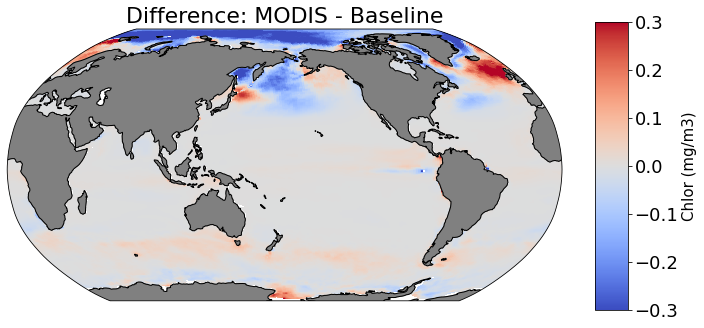

In [40]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.pcolormesh(modis_baseline_diff.TLONG, modis_baseline_diff.TLAT, modis_baseline_diff.modis_baseline_diff, 
                   transform = ccrs.PlateCarree(), norm=TwoSlopeNorm(0), vmin = -0.3, vmax = 0.3, cmap='coolwarm')

axs.set_title('Difference: MODIS - Baseline', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Chlor (mg/m3)', size = 15)
plt.savefig('../plots/modis_baseline_diff.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [41]:
isccp_baseline_diff = 100*(data_mean.isccp_chlor - data_mean.baseline_chlor)/data_mean.baseline_chlor
isccp_baseline_diff = plotting.pop_add_cyclic(isccp_baseline_diff.to_dataset(name = 'isccp_baseline_diff'))

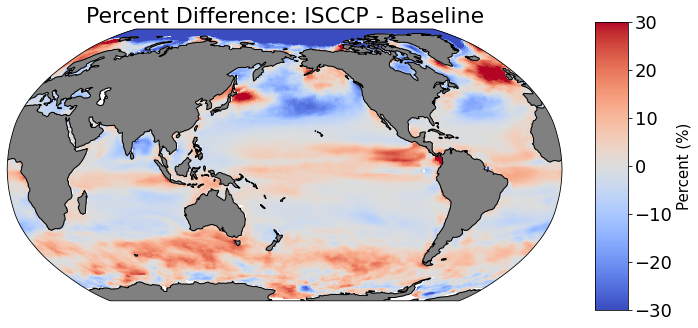

In [43]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.pcolormesh(isccp_baseline_diff.TLONG, isccp_baseline_diff.TLAT, isccp_baseline_diff.isccp_baseline_diff, 
                   transform = ccrs.PlateCarree(), vmin = -30, vmax = 30, cmap='coolwarm')

axs.set_title('Percent Difference: ISCCP - Baseline', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Percent (%)', size = 15)
plt.savefig('../plots/isccp_baseline_per_diff.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

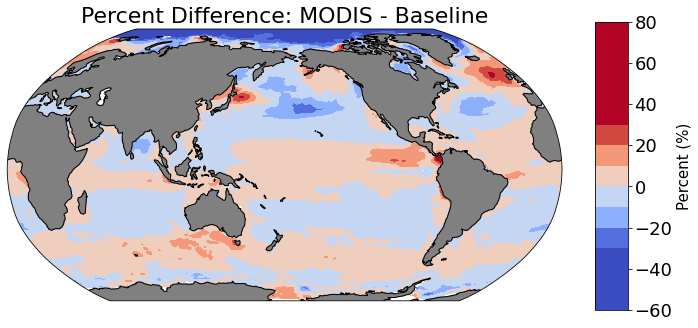

In [45]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.contourf(modis_baseline_per_diff.TLONG, modis_baseline_per_diff.TLAT, modis_baseline_per_diff.modis_baseline_diff, 
                   transform = ccrs.PlateCarree(), vmin = -30, vmax = 30, levels = 14, cmap='coolwarm')

axs.set_title('Percent Difference: MODIS - Baseline', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Percent (%)', size = 15)
# plt.savefig('../plots/modis_baseline_per_diff_contour.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

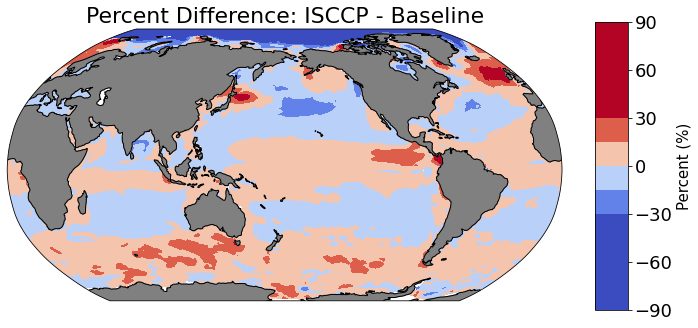

In [46]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.contourf(isccp_baseline_diff.TLONG, isccp_baseline_diff.TLAT, isccp_baseline_diff.isccp_baseline_diff, 
                   transform = ccrs.PlateCarree(), vmin = -30, vmax = 30, levels = 14, cmap='coolwarm')

axs.set_title('Percent Difference: ISCCP - Baseline', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Percent (%)', size = 15)
# plt.savefig('../plots/isccp_baseline_per_diff_contour.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [47]:
modis_chlor_swath_ds = plotting.pop_add_cyclic(data_mean.modis_chlor_swath.to_dataset(name = 'modis_chlor_swath'))

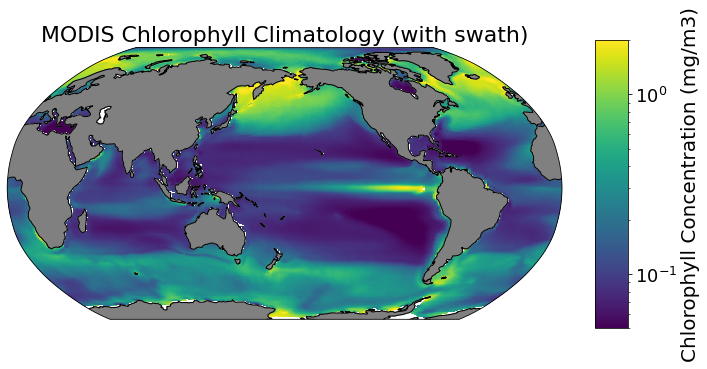

In [48]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

axs.set_title('MODIS Chlorophyll Climatology (with swath)', fontsize = 22)
norm = colors.LogNorm(vmin = 0.05, vmax = 2)

im1 = axs.pcolormesh(modis_chlor_swath_ds.TLONG, modis_chlor_swath_ds.TLAT, modis_chlor_swath_ds.modis_chlor_swath, 
                   transform = ccrs.PlateCarree(), norm=norm, cmap='viridis')

axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

# [left, bottom, width, height]
cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Chlorophyll Concentration (mg/m3)', size = 20)
plt.savefig('../plots/modis_chlor_climatology_swath.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [49]:
# MODIS swath - MODIS daylight
swath_diff = 100*(data_mean.modis_chlor_swath - data_mean.modis_chlor)/data_mean.modis_chlor
modis_swath_diff = plotting.pop_add_cyclic(swath_diff.to_dataset(name = 'modis_swath_diff'))

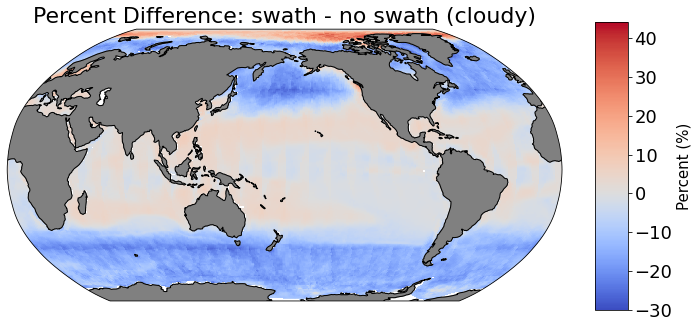

In [50]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.pcolormesh(modis_swath_diff.TLONG, modis_swath_diff.TLAT, modis_swath_diff.modis_swath_diff, 
                   transform = ccrs.PlateCarree(), norm=TwoSlopeNorm(0),  cmap='coolwarm')

axs.set_title('Percent Difference: swath - no swath (cloudy)', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Percent (%)', size = 15)
plt.savefig('../plots/modis_chlor_swath_per_diff.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [51]:
# MODIS swath - MODIS daylight
baseline_swath_diff = 100*(data_mean.baseline_chlor_swath - data_mean.baseline_chlor)/data_mean.baseline_chlor
baseline_swath_diff = plotting.pop_add_cyclic(swath_diff.to_dataset(name = 'baseline_swath_diff'))

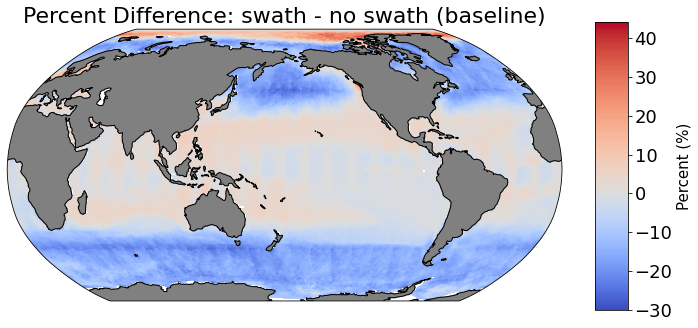

In [52]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.pcolormesh(baseline_swath_diff.TLONG, baseline_swath_diff.TLAT, baseline_swath_diff.baseline_swath_diff, 
                   transform = ccrs.PlateCarree(), norm=TwoSlopeNorm(0),  cmap='coolwarm')

axs.set_title('Percent Difference: swath - no swath (baseline)', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Percent (%)', size = 15)
plt.savefig('../plots/modis_baseline_swath_per_diff.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [53]:
modis_baseline_diff_swath = 100*(data_mean.modis_chlor_swath - data_mean.baseline_chlor_swath)/data_mean.baseline_chlor_swath
modis_baseline_diff_swath = plotting.pop_add_cyclic(modis_baseline_diff_swath.to_dataset(name = 'modis_baseline_diff_swath'))

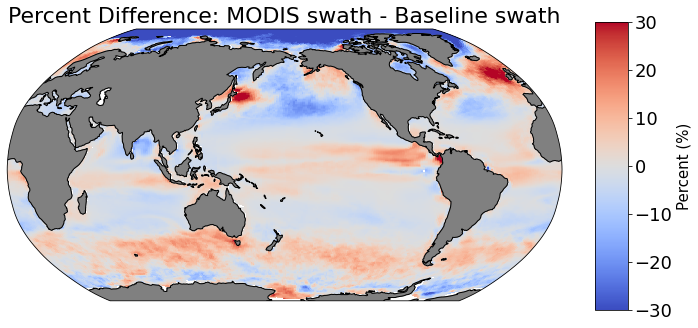

In [54]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.pcolormesh(modis_baseline_diff_swath.TLONG, modis_baseline_diff_swath.TLAT, modis_baseline_diff_swath.modis_baseline_diff_swath, 
                   transform = ccrs.PlateCarree(), vmin = -30, vmax = 30, cmap='coolwarm')

axs.set_title('Percent Difference: MODIS swath - Baseline swath', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Percent (%)', size = 15)
plt.savefig('../plots/modis_baseline_swath_per_diff.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [55]:
modis_total_diff = 100*(data_mean.modis_chlor - data_mean.totChl)/data_mean.totChl
modis_total_diff = plotting.pop_add_cyclic(modis_total_diff.to_dataset(name = 'modis_total_diff'))

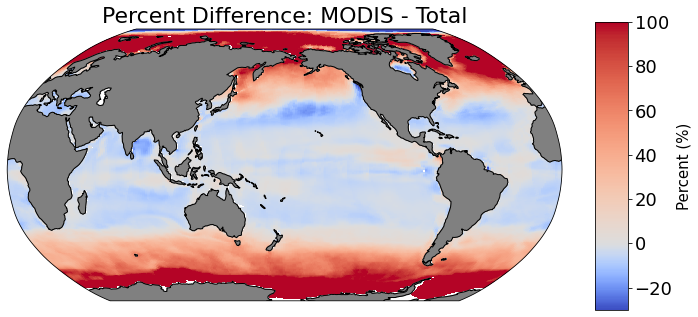

In [57]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.pcolormesh(modis_total_diff.TLONG, modis_total_diff.TLAT, modis_total_diff.modis_total_diff, 
                   transform = ccrs.PlateCarree(), norm=TwoSlopeNorm(0), vmax = 100, vmin=-30, cmap='coolwarm')

axs.set_title('Percent Difference: MODIS - Total', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Percent (%)', size = 15)
plt.savefig('../plots/modis_total_chlor_per_diff.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [59]:
modis_total_diff_swath = 100*(data_mean.modis_chlor_swath - data_mean.totChl)/data_mean.totChl
modis_total_diff_swath = plotting.pop_add_cyclic(modis_total_diff_swath.to_dataset(name = 'modis_total_diff_swath'))

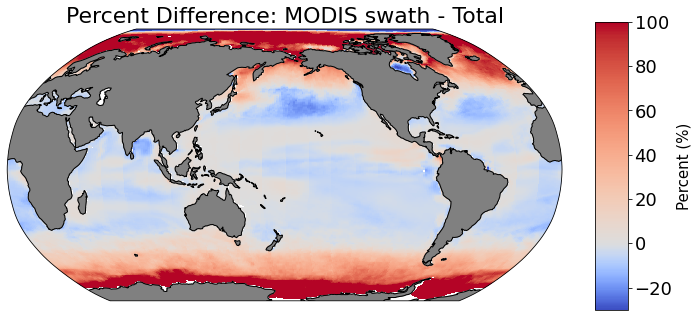

In [63]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.pcolormesh(modis_total_diff_swath.TLONG, modis_total_diff_swath.TLAT, modis_total_diff_swath.modis_total_diff_swath, 
                   transform = ccrs.PlateCarree(), norm=TwoSlopeNorm(0), vmax = 100, vmin=-30, cmap='coolwarm')

axs.set_title('Percent Difference: MODIS swath - Total', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Percent (%)', size = 15)
plt.savefig('../plots/modis_total_chlor_per_diff.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

In [64]:
isccp_total_diff = 100*(data_mean.isccp_chlor - data_mean.totChl)/data_mean.totChl
isccp_total_diff = plotting.pop_add_cyclic(isccp_total_diff.to_dataset(name = 'isccp_total_diff'))

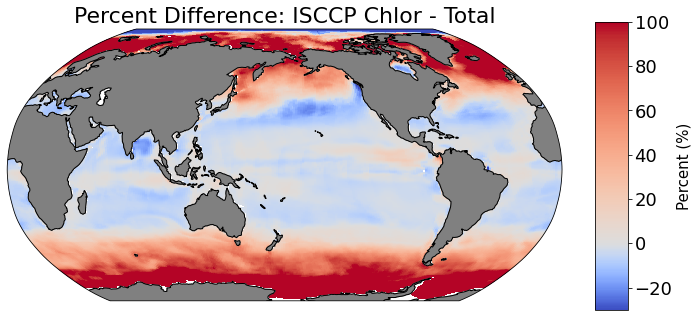

In [65]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}, # ccrs.PlateCarree()
                        figsize=(15,5))

im1 = axs.pcolormesh(isccp_total_diff.TLONG, isccp_total_diff.TLAT, isccp_total_diff.isccp_total_diff, 
                   transform = ccrs.PlateCarree(), norm=TwoSlopeNorm(0), vmax = 100, vmin = -30, cmap='coolwarm')

axs.set_title('Percent Difference: ISCCP Chlor - Total', fontsize = 22)
axs.add_feature(cartopy.feature.LAND, color='grey', zorder =1)
axs.coastlines(color = 'black', linewidth = 1)

cax = fig.add_axes([0.8, 0.1, 0.03, 0.8])
cbar = plt.colorbar(im1, cax = cax)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label = 'Percent (%)', size = 15)
plt.savefig('../plots/isccp_total_chlor_per_diff.png', bbox_inches = 'tight',pad_inches = 0.3, dpi = 300)

# Calculate spatial mean

## Take weighted spatial mean

In [67]:
def weighted_mean(weighted_chlor, weights, TAREA):
    """
    POP writes totChl*weight to history file; that's weighted_chlor.
    We want to include TAREA in our weighting
    """
    return (weighted_chlor*TAREA).sum()/(weights*TAREA).sum()   

In [68]:
def compare_means(mean1, mean2, label1='Cloudy', label2='Baseline'):
    print(f"{label1} global mean: {mean1.data}")
    print(f"{label2} global mean: {mean2.data}")
    diff = mean1 - mean2
    print(f"Difference: {diff.data}")
    print(f"Relative difference: {(100*diff.data/mean2.data):.2f}%")

### Biome Means

In [72]:
cluster.scale(30)

In [75]:
# biome_means_df = pd.read_csv('biome_means_20yr.csv')
biome_means_df = pd.DataFrame()

for biome in range(1,18):
    # if biome in biome_means_df['biome'].unique():
    #     continue
    print(biome)
    mask = (biomes.MeanBiomes==biome)
    TAREA_mask = TAREA.where(mask)
    
    totChl = data.totChl.where(mask).weighted(TAREA_mask.fillna(0)).mean().compute()
    isccp_chlor = weighted_mean(data.totChl_isccp, data.totChl_isccp_wgt, TAREA_mask).compute()
    modis_chlor = weighted_mean(data.totChl_modis, data.totChl_modis_wgt, TAREA_mask).compute()
    baseline = weighted_mean(data.totChl_sat_nocld, data.totChl_sat_nocld_wgt, TAREA_mask).compute()
    modis_chlor_swath = weighted_mean(data.totChl_modis_swath, data.totChl_modis_wgt_swath, TAREA_mask).compute()
    baseline_swath = weighted_mean(data.totChl_sat_nocld_swath, data.totChl_sat_nocld_wgt_swath, TAREA_mask).compute()
    
    df_new = pd.DataFrame(data = {'biome': [biome], 'totChl': [totChl.item()], 'isccp_chlor': [isccp_chlor.item()],
                                  'modis_chlor': [modis_chlor.item()], 'baseline': [baseline.item()],
                                  'modis_chlor_swath': [modis_chlor_swath.item()], 'baseline_swath': [baseline_swath.item()]})
    
    biome_means_df = pd.concat([biome_means_df, df_new])
    biome_means_df.to_csv('../data/biome_means.csv')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


### Global Mean

In [76]:
totChl = data.totChl.weighted(TAREA.fillna(0)).mean().compute()
isccp_chlor = weighted_mean(data.totChl_isccp, data.totChl_isccp_wgt, TAREA).compute()
modis_chlor = weighted_mean(data.totChl_modis, data.totChl_modis_wgt, TAREA).compute()
baseline = weighted_mean(data.totChl_sat_nocld, data.totChl_sat_nocld_wgt, TAREA).compute()
modis_chlor_swath = weighted_mean(data.totChl_modis_swath, data.totChl_modis_wgt_swath, TAREA).compute()
baseline_swath = weighted_mean(data.totChl_sat_nocld_swath, data.totChl_sat_nocld_wgt_swath, TAREA).compute()

global_mean_df = pd.DataFrame(data = {'totChl': [totChl.item()], 'isccp_chlor': [isccp_chlor.item()],
                              'modis_chlor': [modis_chlor.item()], 'baseline': [baseline.item()],
                              'modis_chlor_swath': [modis_chlor_swath.item()], 'baseline_swath': [baseline_swath.item()]})

global_mean_df.to_csv('../data/global_mean.csv')

In [77]:
cluster.close()
client.close()